### The mean-field induction equation

The mean-field induction equation is,
$$ \dfrac{\partial \bar{\mathbf{B}}}{\partial t} = \nabla \times \left[ \bar{\mathbf{V}} \times \bar{\mathbf{B}} + \mathcal{E} - \eta \left( \nabla \times \bar{\mathbf{B}} \right) \right] $$
where $\mathcal{E} = \left( \alpha \bar{\mathbf{B}} \right) - \eta_t \left( \nabla \times \bar{\mathbf{B}} \right)$

We will solve the equations in the cylindrical coordinates (r, $\phi$, z) with the origin at the galactic centre and the z-axis parallel to the galactic angular velocity. 

We have to solve only in the z-direction, we remove all radial or azimuthal variations of the magnetic field $\left(\dfrac{\partial }{\partial r} = \dfrac{\partial }{\partial \phi} = 0 \right)$. 

We are now left with these simple PDE equations to solve,

$$ { \frac{\partial \bar{B}_r}{\partial t} = \eta_T \frac{\partial^2 \bar{B}_r}{\partial z^2} } \qquad \qquad \qquad { \frac{\partial \bar{B}_\phi}{\partial t} = \eta_T \frac{\partial^2 \bar{B}_\phi}{\partial z^2} } \qquad \qquad \qquad { \frac{\partial \bar{B}_z}{\partial t} = \eta_T \frac{\partial^2 \bar{B}_z}{\partial z^2} } $$

-----

### Crank-Nicolson Method for Solving Second-Order PDE

The Crank-Nicolson method is a numerical technique used to solve second-order partial differential equations (PDEs) with more stability and accuracy compared to other methods like the explicit method. It is particularly useful for solving parabolic PDEs, which have a time-dependent component.

Consider a second-order parabolic PDE in the form:

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$

where $u(x, t)$ is the unknown function, $x$ represents spatial coordinates, $t$ represents time, $\alpha$ is a constant, and $f(x, t)$ is a given function.

To discretize this PDE, we use finite differences.
Let $u_i^n$ represent the approximate solution at spatial position $x_i$ and time $t_n$. 
We can approximate the spatial derivatives using central differences, and the time derivative using either forward or backward differences. 
The Crank-Nicolson method takes a midpoint between these two.

The Crank-Nicolson scheme for the above PDE can be written as:

$$
\frac{u_i^{n+1} - u_i^n}{\Delta t} = \frac{\alpha}{2} \left( \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{\Delta x^2} + \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2} \right) 
$$

Rearranging terms, we get:

$$
-\frac{\alpha \Delta t}{2\Delta x^2}u_{i-1}^{n+1} + \left(1 + \frac{\alpha \Delta t}{\Delta x^2}\right)u_i^{n+1} - \frac{\alpha \Delta t}{2\Delta x^2}u_{i+1}^{n+1} = \frac{\alpha \Delta t}{2\Delta x^2}u_{i-1}^n + \left(1 - \frac{\alpha \Delta t}{\Delta x^2}\right)u_i^n + \frac{\alpha \Delta t}{2\Delta x^2}u_{i+1}^n 
$$

This equation can be represented in matrix form:

$$
AU^{n+1} = BU^n
$$

where $A$ and $B$ are tridiagonal matrices representing the coefficients of $u^{n+1}$ and $u^n$ respectively, and $F$ represents the forcing function evaluated at each spatial point.

To solve for $U^{n+1}$, we can rearrange the equation and apply a suitable linear solver.



----

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import math

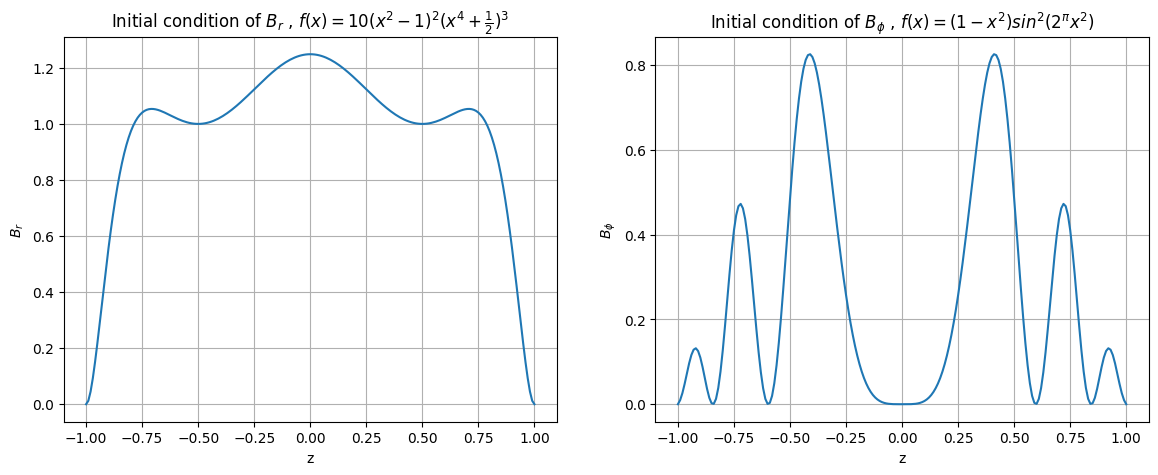

In [268]:
# Initial conditins of the magnetic fields 

def Br0(x):
    return 10*(x**2-1)**2*(x**4+(1/2))**3

def Bphi0(x):
     return (1-x**2)*np.sin(2**np.pi*x**2)**2

# Normalizing the z axis for the galaxy
z = np.linspace(-1, 1, 201)


fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(z,Br0(z))
plt.title(r'Initial condition of $B_{r}$ , $ f(x) = 10(x^{2}-1)^{2}(x^{4}+\frac{1}{2})^{3}$')
plt.xlabel('z')
plt.ylabel('$B_{r}$')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(z,Bphi0(z))
plt.title(r'Initial condition of $B_{\phi}$ , $ f(x) =(1-x^{2})sin^{2}(2^{\pi}x^{2})$')
plt.xlabel('z')
plt.ylabel('$B_{\phi}$')
plt.grid(True)

plt.show()


-----

In [144]:
## Cranck nicolson solver for Partial Differential equations solutions 
 
def crank_nicolson_solve(u0,L,T,Nl,Nt,eta):

    h = L / Nl
    k = T / Nt
    alpha = k*(eta) / h**2
    

    u = np.zeros((Nl + 1, Nt + 1))
    u[:, 0] = u0

    u[0, :] = 0  
    u[Nl, :] = 0  

    # preparing the A and B matrices
    A = np.zeros((Nl-1, Nl-1))
    B = np.zeros((Nl-1, Nl-1))
    for i in range(Nl-1):
        A[i, i] = 2 + 2 * alpha
        B[i, i] = 2 - 2 * alpha
        if i < Nl-2:
            A[i, i+1] = -alpha
            A[i+1, i] = -alpha
            B[i, i+1] = alpha
            B[i+1, i] = alpha

    # inverting A
    A_inv = np.linalg.inv(A)

    b = np.zeros(Nl-1)
    for j in range(1,Nt+1):
        b[0]    = alpha * u[0, j-1] + alpha * u[0, j]
        b[Nl-2] = alpha * u[Nl,j-1] + alpha * u[Nl,j]
        v = B @ u[1:Nl, j-1]
        u[1:(Nl),j] = A_inv @ (v+b)


    return u.T

---

In [358]:
# Total length and spatial step 
L = 2
Nl = 200 
# simulation time and time steps
T = 100
Nt = 100
# Diffusion coefficient
eta = 2e-2

# spatial and time grids
x = np.linspace(-1, 1, 201)
time = np.linspace(0, T, Nt + 1)

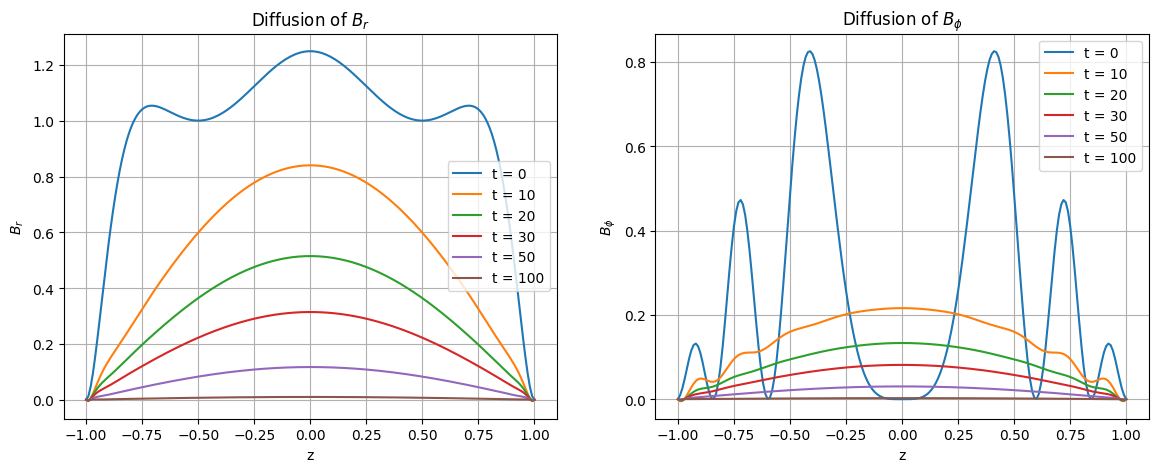

In [194]:
### For B_r
# In itial condition 
Br0 = 10*(x**2-1)**2*(x**4+(1/2))**3

Br = crank_nicolson_solve(Br0,L,T,Nl,Nt,eta)

### For B_phi

Bphi0 = (1-x**2)*np.sin(2**np.pi*x**2)**2

Bphi = crank_nicolson_solve(Bphi0,2,T,Nl,Nt,eta)


# plotting for different time steps
ts = [0,10,20,30,50,100] 
fig = plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
for i in range(len(ts)):
    plt.plot(x,Br[ts[i]],label=f't = {ts[i]}')

plt.legend()
plt.title('Diffusion of $B_{r}$')
plt.xlabel('z')
plt.ylabel('$B_{r}$')
plt.grid(True)

plt.subplot(1,2,2)
for i in range(len(ts)):
    plt.plot(x,Bphi[ts[i]],label=f't = {ts[i]}')

plt.title('Diffusion of $B_{\phi}$')
plt.xlabel('z')
plt.ylabel('$B_{\phi}$')
plt.legend()
plt.grid(True)

----------

The magnitude of the total magnetic field can be given as, 
$\qquad B_{\text{total}} = \sqrt{\bar{B}_r^2 + \bar{B}_\phi^2} $

And the pitch angle is given as, $\qquad p_B = \tan^{-1} \left( \dfrac{\bar{B}_r}{\bar{B}_\phi} \right) \qquad \qquad (\text{where}, -\dfrac{\pi}{2} < p_B < \dfrac{\pi}{2})$

/tmp/ipykernel_444086/2310265149.py:5: RuntimeWarning: divide by zero encountered in divide
  pitch = 180/np.pi*np.arctan(Br[:,1:-1]/Bphi[:,1:-1])


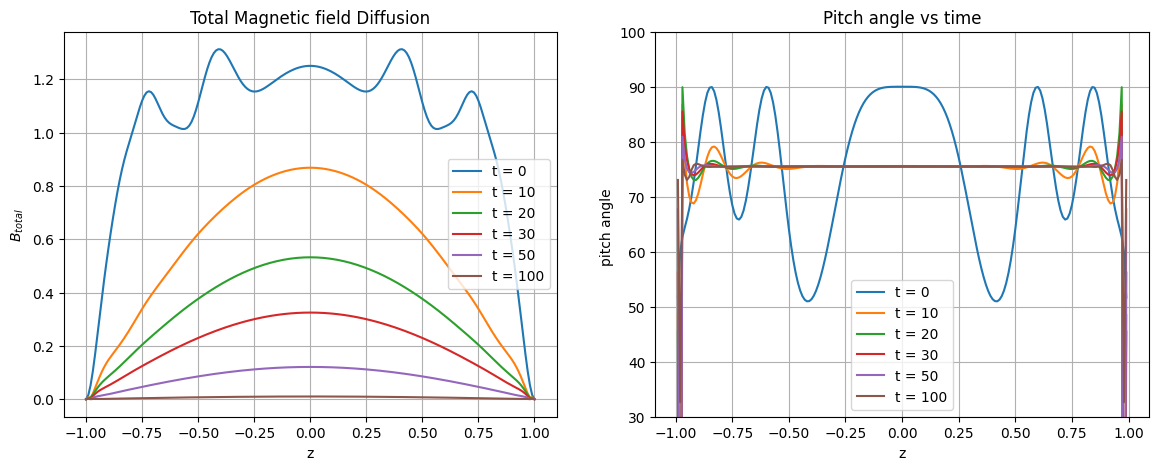

In [199]:
## Total magnetic field 
total_B = np.sqrt(Br**2+Bphi**2)

## Pitch angle 
pitch = 180/np.pi*np.arctan(Br[:,1:-1]/Bphi[:,1:-1])


# plotting for different time steps
ts = [0,10,20,30,50,100]
fig = plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
for i in range(len(ts)):
    plt.plot(x,total_B[ts[i]],label=f't = {ts[i]}')

plt.title('Total Magnetic field Diffusion')
plt.xlabel('z')
plt.ylabel('$B_{total}$')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
for i in range(len(ts)):
    plt.plot(x[1:-1],pitch[ts[i]],label=f't = {ts[i]}')

plt.title('Pitch angle vs time')
plt.ylim(30,100)
plt.xlabel('z')
plt.ylabel('pitch angle ')
plt.legend()
plt.grid(True)

Best-fit line : m = -0.049357 and c = 0.356429


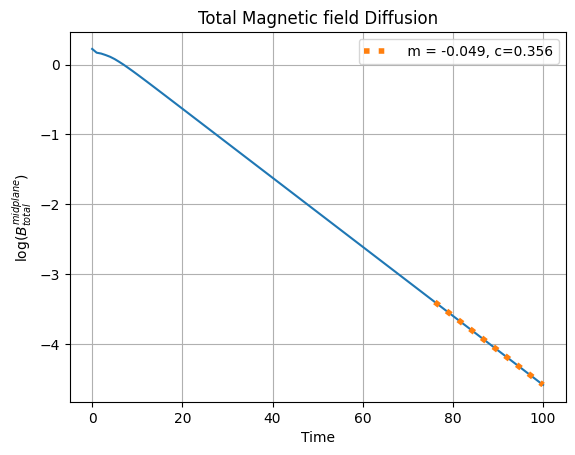

In [264]:
## Plotting the magnetic field decay at z = 0 and fitting it

m, c =  np.polyfit(time[-25:],np.log(total_B[-25:,100]),1)
print(f'Best-fit line : m = {m:.6f} and c = {c:6f}')

plt.plot(time,np.log(total_B[:,100]))
plt.plot(time[-25:], m*time[-25:] + c, ':', linewidth=4,label=f' m = {m:.3f}, c={c:.3f}')
plt.title('Total Magnetic field Diffusion')
plt.xlabel('Time')
plt.ylabel('log$(B^{midplane}_{total})$')
plt.legend()
plt.grid(True)

Decay constant obtained is $ \gamma =  -4.935\times10^{-2}$

---

### Using different initial fields

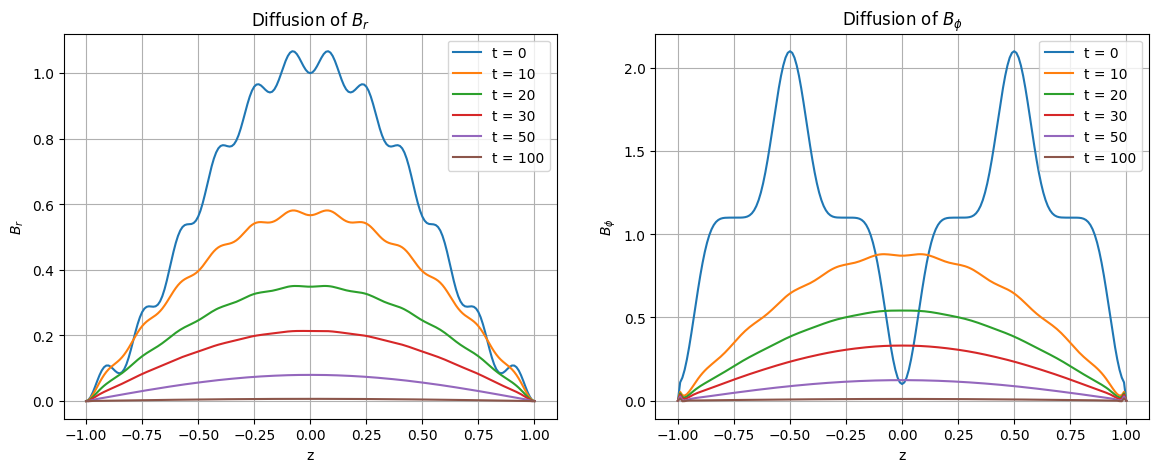

In [362]:
### For B_r
# In itial condition 
Br0 = (1-x**2)**2+0.08*np.sin(6*np.pi*x)**2 
Br = crank_nicolson_solve(Br0,L,T,Nl,Nt,eta)

### For B_phi

Bphi0 = 1.1-np.cos(2*np.pi*x)**5

Bphi = crank_nicolson_solve(Bphi0,2,T,Nl,Nt,eta)


# plotting for different time steps
ts = [0,10,20,30,50,100] 
fig = plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
for i in range(len(ts)):
    plt.plot(x,Br[ts[i]],label=f't = {ts[i]}')

plt.legend()
plt.title('Diffusion of $B_{r}$')
plt.xlabel('z')
plt.ylabel('$B_{r}$')
plt.grid(True)

plt.subplot(1,2,2)
for i in range(len(ts)):
    plt.plot(x,Bphi[ts[i]],label=f't = {ts[i]}')

plt.title('Diffusion of $B_{\phi}$')
plt.xlabel('z')
plt.ylabel('$B_{\phi}$')
plt.legend()
plt.grid(True)

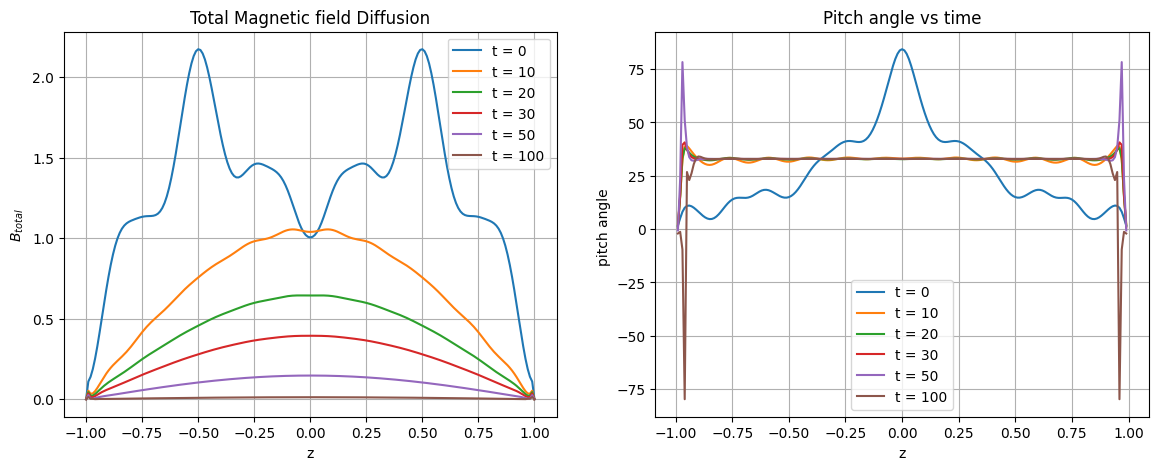

In [363]:
## Total magnetic field 
total_B = np.sqrt(Br**2+Bphi**2)

## Pitch angle 
pitch = 180/np.pi*np.arctan(Br[:,1:-1]/Bphi[:,1:-1])


# plotting for different time steps
ts = [0,10,20,30,50,100]
fig = plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
for i in range(len(ts)):
    plt.plot(x,total_B[ts[i]],label=f't = {ts[i]}')

plt.title('Total Magnetic field Diffusion')
plt.xlabel('z')
plt.ylabel('$B_{total}$')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
for i in range(len(ts)):
    plt.plot(x[1:-1],pitch[ts[i]],label=f't = {ts[i]}')

plt.title('Pitch angle vs time')
# plt.ylim(30,100)
plt.xlabel('z')
plt.ylabel('pitch angle ')
plt.legend()
plt.grid(True)

Best-fit line : m = -0.049357 and c = 0.550838


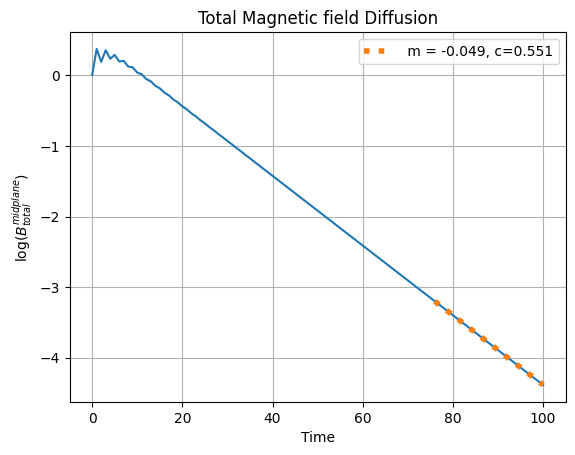

In [364]:
## Plotting the magnetic field decay at z = 0 and fitting it

m, c =  np.polyfit(time[-25:],np.log(total_B[-25:,100]),1)
print(f'Best-fit line : m = {m:.6f} and c = {c:6f}')

plt.plot(time,np.log(total_B[:,100]))
plt.plot(time[-25:], m*time[-25:] + c, ':', linewidth=4,label=f' m = {m:.3f}, c={c:.3f}')
plt.title('Total Magnetic field Diffusion')
plt.xlabel('Time')
plt.ylabel('log$(B^{midplane}_{total})$')
plt.legend()
plt.grid(True)

Decay constant obtained is $ \gamma =  -4.935\times10^{-2}$